In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#Data Processing
training_path = '/kaggle/input/radar-signal-classification/training_set'

transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
full_dataset = datasets.ImageFolder(root=training_path, transform=transforms)

# 80% data train, 20% valdilation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_data, val_data = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)

class_names = train_data.dataset.classes
num_classes = len(class_names)

print(f"Classes: {class_names}")
print(f"Number of classes: {num_classes}")
print(f"Training samples: {train_size}, Validation samples: {val_size}")

#Build Neural Network
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1, bias=False)
        )
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return torch.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return torch.sigmoid(out)

        
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
        
    def forward(self, x):
        
        channel_att = self.channel_attention(x)
        x = x * channel_att

        spatial_att = self.spatial_attention(x)
        x = x * spatial_att

        return x

        
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups=1, stride=1):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.block(x)

        
class ResidualCBAM(nn.Module):
    def __init__(self, in_channels, out_channels, groups=1, stride=1):
        super(ResidualCBAM, self).__init__()
        self.stride = stride
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.dropout = nn.Dropout(0.3)
        self.cbam = CBAM(out_channels, reduction_ratio=8)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

        
    def forward(self, x):
        ResidualCBAM = self.shortcut(x)
        x = self.conv_block(x)
        x = self.cbam(x)
        x = self.dropout(x)
        x += ResidualCBAM
        return F.relu(x)


class MultiScaleModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MultiScaleModule, self).__init__()

        self.h_pool = nn.AdaptiveAvgPool2d((1, None))
        self.h_conv = nn.Conv2d(in_channels, out_channels//2, kernel_size=(1, 3), padding=(0, 1), bias=False)
        
        self.v_pool = nn.AdaptiveAvgPool2d((None, 1))
        self.v_conv = nn.Conv2d(in_channels, out_channels//2, kernel_size=(3, 1), padding=(1, 0), bias=False)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h_att = self.h_conv(self.h_pool(x))
        v_att = self.v_conv(self.v_pool(x))
        
        h_att = F.interpolate(h_att, size=x.size()[2:], mode='bilinear', align_corners=False)
        v_att = F.interpolate(v_att, size=x.size()[2:], mode='bilinear', align_corners=False)
        
        attention = torch.cat([h_att, v_att], dim=1)
        attention = self.sigmoid(attention)
        
        return x * attention

class RadarSignalNW(nn.Module):
    def __init__(self, in_channels=3, num_classes=8):
        super(RadarSignalNW, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        
        # 64x64
        self.Block1 = nn.Sequential(
            ResidualCBAM(32, 32, groups=2),
            ResidualCBAM(32, 32, groups=2)
        )
        self.msm1 = MultiScaleModule(32, 32)
        self.transition1 = nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False)
        
        # 32x32
        self.Block2 = nn.Sequential(
            ResidualCBAM(64, 64, groups=4),
            ResidualCBAM(64, 64, groups=4)
        )
        self.msm2 = MultiScaleModule(64, 64)
        self.transition2 = nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False)
        
        # 16x16
        self.Block3 = nn.Sequential(
            ResidualCBAM(128, 128, groups=8),
            ResidualCBAM(128, 128, groups=8)
        )
        self.msm3 = MultiScaleModule(128, 128)
        
  
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.Block1(x)
        x = self.msm1(x)
        x = self.transition1(x)
        
        x = self.Block2(x)
        x = self.msm2(x)
        x = self.transition2(x)
       
        x = self.Block3(x)
        x = self.msm3(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
model = RadarSignalNW(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10)
summary(model, input_size=(3, 128, 128))

def train(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs, device, early_stopping_patience=10):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    
    save_path = "/kaggle/working/22139012_22139015.pt"
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct / total
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        
        model.eval()
        val_running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = correct / total
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)
        
        scheduler.step(epoch_val_loss)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} - "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f} - "
              f"LR: {current_lr:.6f}")
        
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_val_loss = epoch_val_loss
            example_input = torch.randn(1, 3, 128, 128).to(device) 
            traced_model = torch.jit.trace(model, example_input)
            traced_model.save(save_path)
            print('\t\t\t---------------------------------------------------------')
            print(f"\t\t\t Saved best model at epoch {epoch+1} with Val Acc: {best_val_acc:.4f}")
            print('\t\t\t---------------------------------------------------------')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs with no improvement in Val Acc.")
            break
    
    return model, train_loss, train_acc, val_loss, val_acc, epoch+1

epochs = 100
model, train_loss, train_acc, val_loss, val_acc, stop_ep = train(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs, device, early_stopping_patience=10)

print("Training completed. Best model save!")

Classes: ['B-FM', 'Barker', 'CPFSK', 'DSB-AM', 'GFSK', 'LFM', 'Rect', 'SSB-AM']
Number of classes: 8
Training samples: 5120, Validation samples: 1280
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
          Identity-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           1,024
       BatchNorm2d-6           [-1, 32, 64, 64]              64
              ReLU-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           4,608
       BatchNorm2d-9           [-1, 32, 64, 64]              64
             ReLU-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 32, 64, 64]           1,024
      BatchNorm2d

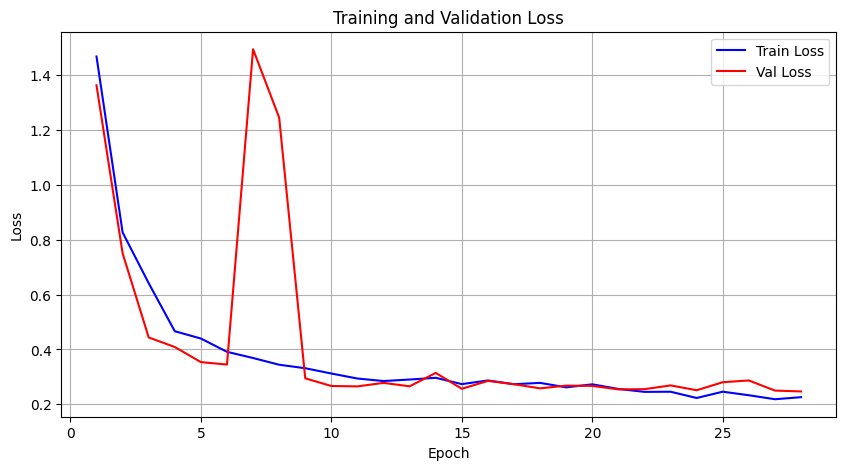

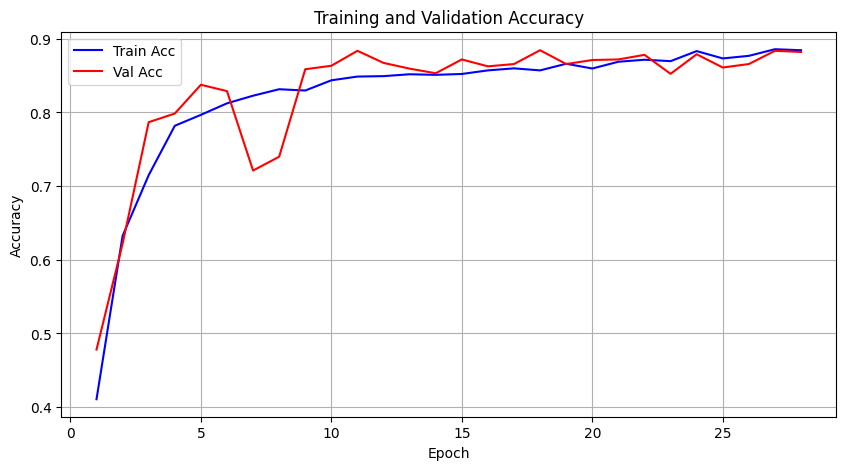

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, stop_ep+1), train_loss, label='Train Loss', color='blue')
plt.plot(range(1, stop_ep+1), val_loss, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, stop_ep+1), train_acc, label='Train Acc', color='blue')
plt.plot(range(1, stop_ep+1), val_acc, label='Val Acc', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
def test(model, test_loader, device):
    correct = 0
    total = 0
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = correct / total
    test_loss = test_loss / len(test_loader)
    
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy

In [5]:
test_path = '/kaggle/input/tuandat-data/radar_split_train_val_test/test'

test_dataset = datasets.ImageFolder(root=test_path, transform=transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
model = torch.jit.load('/kaggle/working/22139012_22139015.pt', map_location=device)
model.eval()
test_loss, test_accuracy = test(model, test_loader, device)

Test Loss: 0.2438, Test Accuracy: 0.8672
